In [94]:
from __future__ import annotations

import importlib
import json
import math
import pathlib
import re
from datetime import datetime

import plotly.express as px
import polars
import theme

importlib.reload(theme)

<module 'theme' from '/home/jgpaul/workspace/sc24-proxystore-analysis/notebooks/theme.py'>

In [95]:
def read_log(filepath: pathlib.Path | str) -> list[str]:
    with open(filepath) as f:
        return f.readlines()

In [96]:
def get_log_timestamp(log: str) -> datetime.datetime:
    parts = log.split(' - ')
    return datetime.strptime(parts[0], '%Y-%m-%d %H:%M:%S,%f')


def get_batch_index(log: str) -> int:
    matches = re.search('\(batch: (\d+)\)', log)
    return int(matches.group(1))


def parse_baseline_inference_times(logs: list[str]) -> polars.DataFrame:
    logs = [json.loads(l) for l in logs]

    batches = [
        {
            'index': i,
            'submitted': datetime.fromtimestamp(log['timestamp']['created']),
            'received': datetime.fromtimestamp(
                log['timestamp']['result_received'],
            ),
        }
        for i, log in enumerate(logs)
    ]

    df = polars.from_dicts(batches)
    df = df.with_columns(
        (polars.col('received') - polars.col('submitted')).alias('timespan'),
    )

    return df


def parse_proxystream_inference_times(logs: list[str]) -> polars.DataFrame:
    submitted_logs = [l for l in logs if 'Sending inference input' in l]
    received_logs = [l for l in logs if 'Received inference output' in l]

    submitted_times = {
        get_batch_index(l): get_log_timestamp(l) for l in submitted_logs
    }
    received_times = {
        get_batch_index(l): get_log_timestamp(l) for l in received_logs
    }
    batches = set(submitted_times.keys()) & set(received_times.keys())

    batches = [
        {
            'index': i,
            'submitted': submitted_times[i],
            'received': received_times[i],
        }
        for i in batches
    ]

    df = polars.from_dicts(batches)
    df = df.with_columns(
        (polars.col('received') - polars.col('submitted')).alias('timespan'),
    )

    return df

In [145]:
def plot_distributions(baseline_times, proxystream_times, layout=None):
    baseline_times = baseline_times.select(
        polars.col('timespan').dt.total_microseconds() / 1e6,
        polars.lit('Baseline').alias('method'),
    )
    proxystream_times = proxystream_times.select(
        polars.col('timespan').dt.total_microseconds() / 1e6,
        polars.lit('ProxyStream').alias('method'),
    )

    times = polars.concat([baseline_times, proxystream_times])

    bin_width = 0.1
    nbins = math.ceil(
        (times['timespan'].max() - times['timespan'].min()) / bin_width,
    )
    colors = {
        'Baseline': px.colors.qualitative.Bold[1],
        'ProxyStream': px.colors.qualitative.Bold[0],
    }

    fig = px.box(
        x=times['timespan'],
        color=times['method'],
        color_discrete_map=colors,
        category_orders={'timespan': list(colors.keys())},
    )
    layout = {} if layout is None else layout
    fig.update_layout(
        xaxis_title='Inference Time (s)',
        # yaxis_title='Count',
        yaxis=dict(autorange='reversed'),
        legend=dict(
            yanchor='bottom',
            y=0.02,
            xanchor='right',
            x=0.995,
            title=None,
        ),
        template='proxystore',
        boxgap=0,
        **layout,
    )
    return fig

Baseline Mean (std): 3.264023 ± 6.615977
ProxyStream Mean (std): 0.663543 ± 0.245087


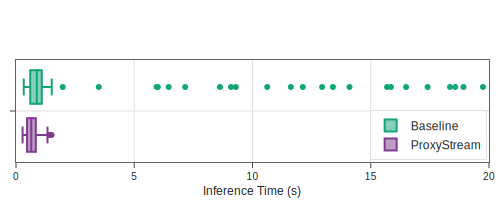

In [146]:
baseline_logs = read_log(
    '../data/polaris/4-deepdrivemd/bba-baseline-160324-174754/result/inference.json',
)
proxystream_logs = read_log(
    '../data/polaris/4-deepdrivemd/bba-proxystream-160324-163305/runtime.log',
)

baseline_times = parse_baseline_inference_times(baseline_logs)
proxystream_times = parse_proxystream_inference_times(proxystream_logs)

baseline_summary = (
    baseline_times['timespan'].mean().total_seconds(),
    baseline_times['timespan'].std().total_seconds(),
)
proxystream_summary = (
    proxystream_times['timespan'].mean().total_seconds(),
    proxystream_times['timespan'].std().total_seconds(),
)
print(f'Baseline Mean (std): {baseline_summary[0]} ± {baseline_summary[1]}')
print(
    f'ProxyStream Mean (std): {proxystream_summary[0]} ± {proxystream_summary[1]}',
)

layout = dict(width=500, height=200, xaxis_range=[0, 20])

fig = plot_distributions(baseline_times, proxystream_times, layout)
fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/polaris/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '4-ddmd-inference-dist.pdf')